In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch

from sbi.inference import prepare_for_sbi
from sbi.simulators.simutils import simulate_in_batches
from sbi.analysis import pairplot
from consbi.simulators import RuleSimulator, PetersRuleSimulator, peters_rule_subcellular

import sys
sys.path.append("../")

from utils import plot_diag, plot_offdiag

import matplotlib as mpl
plt.rcParams.update(mpl.rcParamsDefault)
plt.style.use('plotting_settings.mplstyle')

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load inferred posteriors from file
we performed inference for each subvolumes size for the neuron-level rule (5 sizes), and once for the synapse-level rule given subvolume size 1µm.

So, six files in total.

In [2]:
# Select posterior files.
files = [
    "../default_rule_benchmark/results/amortized_posterior_N1000000_PetersSubCellular_ss50_ep288.p",
    "../default_rule_benchmark/results/amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs50_ep253.p",
    "../default_rule_benchmark/results/amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs25_ep261.p",
    "../default_rule_benchmark/results/amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs10_ep130.p",
    "../default_rule_benchmark/results/amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs5_ep242.p",
    "../default_rule_benchmark/results/amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs1_ep211.p",
]

In [3]:
xo_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
N = 1000
css = [1, 50, 25, 10, 5, 1]
rule_labels = [rf"voxel size {i}$\mu$m" for i in css]
xo = torch.tensor([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])

## Calculate posterior MAP for each file

In [4]:
maps = []
for idx, file in enumerate(files):
    with open(file, "rb") as fh:
        prior, posterior, seed, de = pickle.load(fh).values()
        
    maps.append(posterior.map(x=xo, show_progress_bars=False))

### Simulate data for fixed rule variants (Peters)
To compare inference vs. fixed rules (Peters' rule), we first get the predictive distributions for these two rules: for the synapse-level and for the neuron-level.

In [5]:
# Simulate subcellular rule with fixed p=1 (Peters)
with open(files[0], "rb") as fh:
    prior, posterior, seed, de = pickle.load(fh).values()
simulator = RuleSimulator(
            "/home/janfb/data/spp/petersSubcellular",
            peters_rule_subcellular,
            verbose=False,
            num_subsampling_pairs=50,
            experiment_name="peters-subcellular",
        )
batch_simulator, prior = prepare_for_sbi(simulator, prior)
xos_fixed = []
xos_fixed.append(simulate_in_batches(
    batch_simulator, torch.ones(1000, 1), sim_batch_size=10, num_workers=20
))

# Simulate common cubes rule with fixed th=1 (Peters)
with open(files[1], "rb") as fh:
    prior, posterior, seed, de = pickle.load(fh).values()
model = PetersRuleSimulator(
    "/home/janfb/data/spp/model_data_2020-10-12/",
    "/home/janfb/data/spp/inferencePetersRule/",
    num_subsampling_pairs=50,
    cube_size=1, 
    feature_set_name="set-6",
)

def simulator(th):
    return model.rule(th, feature=model.common_cubes, connection_fun=model.cutoff_rule)
batch_simulator, prior = prepare_for_sbi(simulator, prior)
xos_fixed.append(simulate_in_batches(
    batch_simulator, torch.ones(1000, 1), sim_batch_size=10, num_workers=20
))

constraint 0, num rows (with overlap) 260255
constraint 1, num rows (with overlap) 63243
constraint 2, num rows (with overlap) 35558
constraint 3, num rows (with overlap) 103806
constraint 4, num rows (with overlap) 37142
constraint 5, num rows (with overlap) 38234
constraint 6, num rows (with overlap) 67755



using feature set-6


### For each inference, simulate prior and posterior predictive
Next we sample the posterior and simulate the posterior (and prior) predictives for each of the six posteriors.

In [6]:
ths = []
thos = []
xs = []
xos = []
features = []

for idx, file in enumerate(files):
    with open(file, "rb") as fh:
        prior, posterior, seed, de = pickle.load(fh).values()
    
    if idx > 0:     
        model = PetersRuleSimulator(
            "/home/janfb/data/spp/model_data_2020-10-12/",
            "/home/janfb/data/spp/inferencePetersRule/",
            num_subsampling_pairs=50,
            cube_size=css[idx], 
            feature_set_name="set-6",
        )
        features.append(model.common_cubes)

        def simulator(th):
            return model.rule(th, feature=model.common_cubes, connection_fun=model.cutoff_rule)
    else:
        simulator = RuleSimulator(
            "/home/janfb/data/spp/petersSubcellular",
            peters_rule_subcellular,
            verbose=False,
            num_subsampling_pairs=50,
            experiment_name="peters-subcellular",
        )

    # generate params.
    ths.append(prior.sample((N,)))
    thos.append(posterior.sample((N,), x=xo, show_progress_bars=False))
    
    # run simulations.
    simulator, prior = prepare_for_sbi(simulator, prior)
    xs.append(simulate_in_batches(simulator, ths[-1], sim_batch_size=10, num_workers=20))
    xos.append(simulate_in_batches(simulator, thos[-1], sim_batch_size=10, num_workers=20))

constraint 0, num rows (with overlap) 260255
constraint 1, num rows (with overlap) 63243
constraint 2, num rows (with overlap) 35558
constraint 3, num rows (with overlap) 103806
constraint 4, num rows (with overlap) 37142
constraint 5, num rows (with overlap) 38234
constraint 6, num rows (with overlap) 67755



using feature set-6



using feature set-6



using feature set-6



using feature set-6



using feature set-6


In [19]:
# The features are the number of shared subvolumes needed for figure panel A.
features = np.array(features).squeeze().T

In [12]:
# from list to tensor
thos = torch.stack(thos).squeeze().T.numpy()

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

In [14]:
# short fun to colorize boxplots
def color_boxplot(thos, bp, colors, alpha=0.7):
    for key in ['boxes', 'medians']:
        for i, b in enumerate(bp[key]):
            b.set(color=colors[i], alpha=alpha)
    
    for idx, patch in enumerate(bp['boxes']):
        patch.set_facecolor(colors[idx])
        patch.set_alpha(alpha)

    for key in ['whiskers', 'caps']:
        for i in range(thos.shape[1]):
            bp[key][2*i].set(color=colors[i], alpha=alpha)
            bp[key][2*i+1].set(color=colors[i], alpha=alpha)

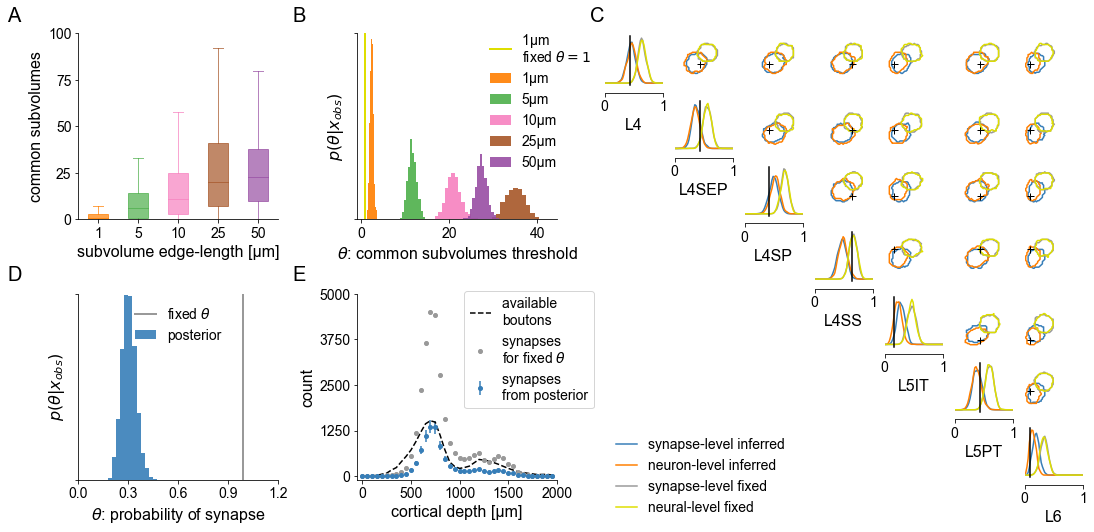

In [149]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=.1, hspace=0, width_ratios=[.5, .5])
alpha=0.9
handlelength = 1.5

# First column
grid1 = outer_grid[0, 0].subgridspec(2, 2, wspace=0.4, hspace=.4)
ax1 = grid1.subplots()
# second columns
grid2 = outer_grid[0, 1].subgridspec(7, 7, wspace=0.2, hspace=.2)
ax2 = grid2.subplots()

# Common cubes features
plt.sca(ax1[0, 0])
bp1 = plt.boxplot(features[:, ::-1], notch=False, showfliers=False, 
#                   showmeans=True,
                  flierprops=dict(markeredgecolor="grey", marker="+", markersize=5),
                  labels=css[1:][::-1],
                  patch_artist=True, 
                 )
# plt.yscale("log")
plt.ylabel("common subvolumes")
plt.xlabel(r"subvolume edge-length [µm]")
color_boxplot(thos[:, 1:], bp1, colors[1:])
plt.ylim(0, 100)
plt.yticks(np.linspace(0, 100, 5))

# Common cubes posteriors
plt.sca(ax1[0, 1])
# plt
for ii in range(1, 6):
    plt.hist(thos[:, -ii], bins=15, histtype="stepfilled", 
             alpha=alpha, 
             color=colors[:7][ii],
             density=True, 
             label=f"{css[-ii]}µm"
            )
plt.xlabel(r"$\theta$: common subvolumes threshold")
plt.ylabel(r"$p(\theta | x_{obs})$")
plt.ylim(0, 1)
plt.yticks([0, 1], ["", ""])
plt.axvline(x=1, color=colors[8], label="1µm \nfixed "+r"$\theta=1$", lw=2)
plt.legend(bbox_to_anchor=(0.6, .2), handlelength=1.5,)

# Subcellular rule posterior
plt.sca(ax1[1, 0])
plt.hist(thos[:, 0], bins=np.arange(0, 1, 0.025), histtype="stepfilled", 
         alpha=alpha, 
         color=colors[0],
         density=True, 
         label="posterior"
        )
plt.ylabel(r"$p(\theta | x_{obs})$")
plt.xlabel(r"$\theta$: probability of synapse")
plt.axvline(x=.99, color=colors[6], label=r"fixed $\theta$", lw=2)
plt.xlim(0, 1.2)
plt.ylim(0, 9)
plt.yticks([0, 9], ["", ""])
plt.xticks(np.linspace(0, 1.2, 5))
plt.legend(loc=9, 
           handlelength=handlelength,
#            bbox_to_anchor=(5.5, -6), 
          );

fig, ax2 = pairplot([xos[0], xos[-2], xos_fixed[0], xos_fixed[1]], points=xo, 
                    points_colors=["k"], 
                    points_offdiag=dict(marker="+", markersize=7), 
                    samples_colors = [colors[0], colors[1], colors[6], colors[8]],
                    labels=xo_labels,
         limits=[[0, 1]]*7,
         diag="kde",
         hist_diag=dict(histtype="step", bins=10),
         upper="contour", 
         contour_offdiag=dict(levels=[0.95]),
         fig=fig, 
         axes=ax2,
        )
plt.sca(ax2[0, 0])
plt.legend(["synapse-level inferred", 
            "neuron-level inferred", 
            "synapse-level fixed", 
            "neural-level fixed",
           ], 
           handlelength=handlelength,
           bbox_to_anchor=(3.3, -6.2));

ax = ax1[1, 1]
plt.sca(ax)
markersize = 4
ax.plot(depths, boutons, linestyle='--', 
#         marker='o', 
        color='k', label='available \nboutons')
ax.errorbar(depths, x_perDepth.mean(0), yerr=x_perDepth.std(0), 
            linestyle='None', 
            marker='o', ms=markersize,
            color=colors[0], 
            label='synapses \nfrom posterior')
ax.plot(depths, xp1_perDepth, 
        linestyle='None', 
        marker='o', ms=markersize,
        color=colors[6], 
        label="synapses \nfor fixed "+r"$\theta$")   
ax.set_ylabel(r'count')
ax.set_xlabel(r'cortical depth [µm]')
plt.legend(handlelength=handlelength, 
           bbox_to_anchor=(.5, 1.05), 
#            markerfirst=False,
           frameon=True,
          )
plt.ylim(-100, 5000)
plt.yticks(np.linspace(0, 5000, 5))
plt.xlim(-50, 2000)
plt.xticks(np.linspace(0, 2000, 5))

# Add Letters.
weight = "regular"
fontsize = 20
x = 0.07
y = 0.92
dy = .47
dx = 0.29
fig.text(x, y, "A", fontsize=fontsize, fontweight=weight)
fig.text(dx, y, "B", fontsize=fontsize, fontweight=weight)
fig.text(dx + 0.23, y, "C", fontsize=fontsize, fontweight=weight);
fig.text(x, dy, "D", fontsize=fontsize, fontweight=weight)
fig.text(dx, dy, "E", fontsize=fontsize, fontweight=weight);

In [150]:
fig.savefig("figure5-rule-variants.png", dpi=300, bbox_inches='tight')